In [6]:
import numpy as np
import pandas as pd
import nltk
import gensim
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import json
import io

# 1.import data and convert it to dataframe

In [7]:
business_json_file = 'business.json'
user_json_file = 'user.json'
review_json_file = 'review.json'

In [8]:
business = []
user = []
review = []
for line in open(business_json_file, 'r'):
    business.append(json.loads(line))

In [9]:
for line in open(user_json_file, 'r'):
    user.append(json.loads(line))

In [10]:
for line in open(review_json_file, 'r'):
    review.append(json.loads(line))

In [11]:
business_df = pd.DataFrame.from_records(business)
user_df = pd.DataFrame.from_records(user)
review_df = pd.DataFrame.from_records(review)

# 2. extract the userid,businessid, text, rating

#### ***test: we extract 10k reviews

In [14]:
review_df = review_df.loc[:10000,['business_id','user_id','text','stars']]

In [15]:
review_df.head() 

,business_id,user_id,text,stars
0,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,Total bill for this horrible service? Over $8G...,1.0
1,NZnhc2sEQy3RmzKTZnqtwQ,yXQM5uF2jS6es16SJzNHfg,I *adore* Travis at the Hard Rock's new Kelly ...,5.0
2,WTqjgwHlXbSFevF32_DJVw,n6-Gk65cPZL6Uz8qRm3NYw,I have to say that this office really has it t...,5.0
3,ikCg8xy5JIg_NGPx-MSIDA,dacAIZ6fTM6mqwW5uxkskg,Went in for a lunch. Steak sandwich was delici...,5.0
4,b1b1eb3uo-w561D0ZfCEiQ,ssoyf2_x0EQMed6fgHeMyQ,Today was my second out of three sessions I ha...,1.0


# 3.extract topic

#### 3.1 remove the stopword

In [16]:
review_stopword = gensim.parsing.preprocessing.STOPWORDS
add_stopword = ['food','place','lot']
review_stopword = review_stopword.union(set(add_stopword))

In [18]:
from nltk import pos_tag
is_noun = lambda pos: pos[:2] == 'NN'

# lemmatizing
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(text)

# Tokenize and lemmatize
def preprocess(text):
    tokens = []
    for word in text.split():
        if word.isalpha() == True:
            tokens.append(word.lower())
    #remove stopwords
    tokens = [w for w in tokens if not w in review_stopword]
    tokens = [w for w in tokens if not len(w)<3]
    #keep only noun
    tokens = [w for (w, pos) in pos_tag(tokens) if is_noun(pos)]
    #remove duplicate
    tokens = list(dict.fromkeys(tokens))
    tokens = [lemmatize(w) for w in tokens] 
            
    return tokens

review_df['text'] = review_df['text'].apply(lambda x: preprocess(x))

#### 3.2 duplicate the words according to the stars

In [30]:
review_df['text'] = review_df['text'] * review_df['stars'].apply(int)

In [33]:
reviews = review_df['text']
# Associate words to a numeric ID
dictionary = gensim.corpora.Dictionary(reviews) 
# Transform the collection of texts to a numerical form
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews] 

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=bow_corpus, texts=reviews, start=10, limit=20, step=1)

#### 3.3 

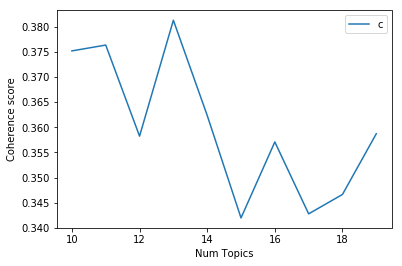

In [38]:
limit=20; start=10; step=1;
x = range(start, limit, step)

plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### 3.4 build the LDA model

In [39]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [40]:
for idx in range(5):
    # Print the first 16 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))

Topic #0: 0.013*"time" + 0.012*"chicken" + 0.011*"try" + 0.010*"flavor" + 0.009*"service" + 0.009*"sandwich" + 0.008*"sauce" + 0.007*"cream" + 0.007*"pork" + 0.007*"dish"
Topic #1: 0.018*"staff" + 0.013*"room" + 0.011*"bar" + 0.009*"area" + 0.008*"price" + 0.008*"people" + 0.008*"way" + 0.007*"owner" + 0.007*"thing" + 0.007*"night"
Topic #2: 0.041*"time" + 0.024*"service" + 0.020*"customer" + 0.010*"people" + 0.009*"thing" + 0.009*"price" + 0.008*"day" + 0.008*"experience" + 0.008*"review" + 0.008*"year"
Topic #3: 0.013*"service" + 0.011*"order" + 0.010*"lunch" + 0.009*"staff" + 0.009*"time" + 0.009*"taco" + 0.008*"thing" + 0.008*"love" + 0.007*"dog" + 0.007*"restaurant"
Topic #4: 0.030*"service" + 0.016*"price" + 0.015*"time" + 0.014*"burger" + 0.010*"order" + 0.009*"drink" + 0.008*"fry" + 0.008*"restaurant" + 0.008*"family" + 0.008*"portion"


In [41]:
# Displaying topics in a table (a better visualisation)
word_dict = {};
for i in range(5):
    words = lda_model.show_topic(i, topn = 50)
    word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words]
word_dict = pd.DataFrame(word_dict)

In [42]:
topic_word = {}
for i in range(1,6):
    word_list = []
    for w in word_dict.iloc[:,i-1]:
        word_list.append(w)
    topic_word[i] = word_list

In [43]:
new_list = []
for k, v in topic_word.items():
    new_list.append([k,v])
    
new_list = pd.DataFrame(data = new_list)

In [44]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        ##
        ##
        ##
        # Add the row code here
        ##
        ##
        ##
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
#                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [45]:
# Warning: This cell takes quite some time to run
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'reviewTxt']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,reviewTxt
0,0,1.0,0.5278,"[crook, charge, pill, cent, hospital, er]"
1,1,2.0,0.7352,"[fan, blowout, stranger, chain, flawless, gree..."
2,2,2.0,0.9841,"[office, assistant, procedure, jewel, bailey, ..."
3,3,4.0,0.5235,"[steak, sandwich, caesar, salad, perfect, drin..."
4,4,2.0,0.7560,"[today, session, session, tell, meredith, enjo..."
5,5,0.0,0.3977,"[admit, group, friend, dinner, menu, ordering,..."
6,6,0.0,0.5368,"[tracy, dessert, hong, kong, year, selection, ..."
7,7,2.0,0.9097,"[staff, quality, review, year, service, worth,..."
8,8,4.0,0.5038,"[rusulka, vanilla, sweet, notch, miss, beer, c..."
9,9,1.0,0.9189,"[giant, buy, deal, giant, buy, deal, giant, bu..."


In [46]:
word_dict

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,time,staff,time,service,service
1,chicken,room,service,order,price
2,try,bar,customer,lunch,time
3,flavor,area,people,staff,burger
4,service,price,thing,time,order
5,sandwich,people,price,taco,drink
6,sauce,way,day,thing,fry
7,cream,owner,experience,love,restaurant
8,pork,thing,review,dog,family
9,dish,night,year,restaurant,portion
